# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??

In [13]:
import copy
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import time as thetime

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from Functions import *

# To display tables in HTML output
from IPython.display import HTML, display

from Functions import *

### Read in formatted data

In [2]:
data = pd.read_csv("formatted_data_for_modelling.csv", index_col = False)

### Get rid of columns that seem obviously irrelevant

In [3]:
data = data.drop(['Pressure', 'Humidity'],axis=1) # lights?
# Remove the columns based on hours (as these are replaced by the categorical ones)
data = data[data.columns.drop(list(data.filter(regex='h_')))]

### Keep only sensors with relatively complete data

In [4]:
### Filter to include just sensors which we know have quite complete data 
data = data[data['sensor_id'].isin([2,6,9,10,14,18])]
data.reset_index(inplace=True, drop = True)

In [5]:
df = data[data.columns.drop(list(data.filter(regex='buildings_|furniture_|landmarks_')))]

In [23]:
# for column in df.columns:
#     print(column)

## Prepare data for modelling - split into predictor/predictand variables

In [38]:
# The predictor variables
Xfull = df.drop(['hourly_counts'], axis =1)

# The variable to be predicted
Yfull = df['hourly_counts'].values

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(Xfull, Yfull, test_size=0.6666, random_state=123)

#### Standardize both training and testing data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 
feature_list = list(Xfull.columns)

## Modelling - Linear regression

In [28]:
#### Fit model
model = LinearRegression()
model.fit(X_train, Y_train)

### Print results
print('Training score: ', model.score(X_train, Y_train))
print('Test score: ', model.score(X_test, Y_test))
print('CV score: ', (cross_val_score(model, X_train, Y_train)).mean())

Training score:  0.5193092147444919
Test score:  0.5199127298752717
CV score:  0.5189907980484882


In [31]:
# Make predictions on the testing data
predictions = model.predict(X_test)
residuals = pd.DataFrame({'Predictions':predictions,'RealValues': Y_test})
residuals['residuals'] = residuals.RealValues - residuals.Predictions

# Not sure what this does
(mean_squared_error(Y_test, predictions))**0.5

# Collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()

In [32]:
# Make predictions on the testing data
predictions = model.predict(X_test)
residuals = pd.DataFrame({'Predictions':predictions,'RealValues': Y_test})
residuals['residuals'] = residuals.RealValues - residuals.Predictions

# Not sure what this does
(mean_squared_error(Y_test, predictions))**0.5

# Collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()

In [33]:
feature_importance= df_coef.sort_values(by = 'coefficients', ascending = False)
feature_importance.reset_index(inplace = True)

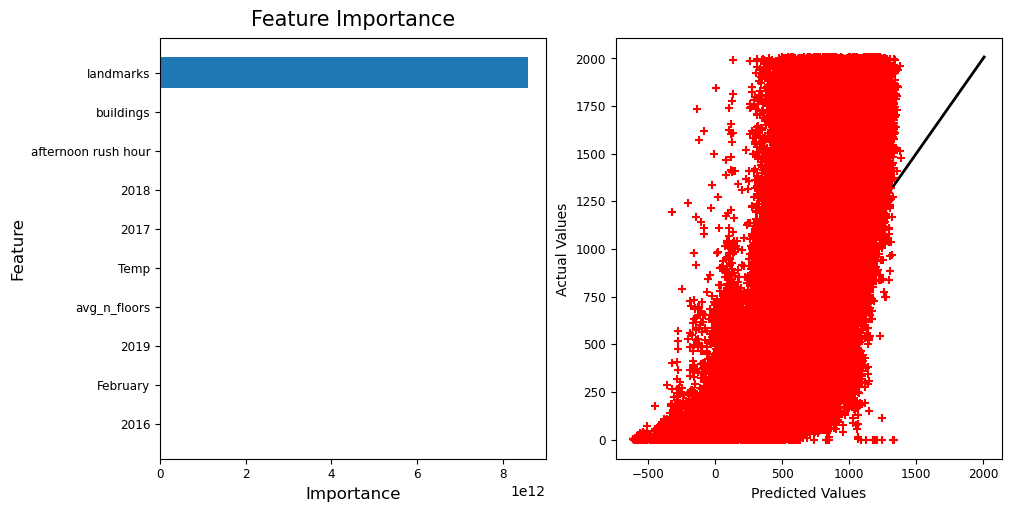

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (10,5))

axs[0].barh(feature_importance['index'][:10], feature_importance['coefficients'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

axs[1].scatter(residuals.Predictions, Y_test, s=30, c='r', marker='+', zorder=10)
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
axs[1].set_xlabel("Predicted Values", size=10)
axs[1].set_ylabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')
plt.show()

## Modelling - Random forest regressor

In [14]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train);

In [36]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 119.5 degrees.


In [39]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 119.5 degrees.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# # Pull out one tree from the forest
# tree = rf.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_png('tree.png')

In [ ]:
# # Limit depth of tree to 3 levels
# rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
# rf_small.fit(X_train, Y_train)
# # Extract the small tree
# tree_small = rf_small.estimators_[5]
# # Save the tree as a png image
# export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# (graph, ) = pydot.graph_from_dot_file('small_tree.dot')

In [41]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
feature_importances = pd.DataFrame({'feature': feature_list,'importance':importances})      
feature_importances= feature_importances.sort_values(by = 'importance', ascending = False)

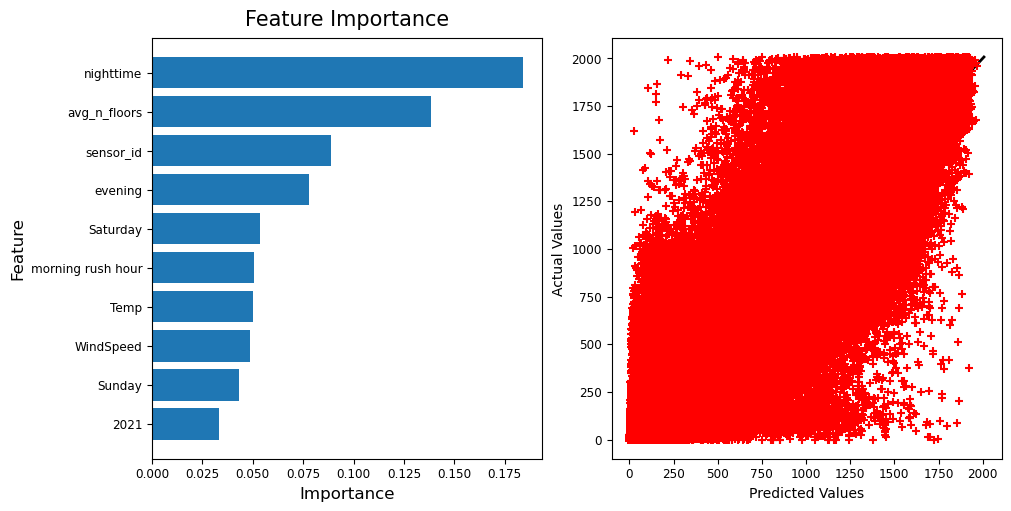

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (10,5))

axs[0].barh(feature_importances['feature'][:10], feature_importances['importance'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

axs[1].scatter(predictions, Y_test, s=30, c='r', marker='+', zorder=10)
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
axs[1].set_xlabel("Predicted Values", size=10)
axs[1].set_ylabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')
plt.show()

## Ridge and Lasso Regulariztion
Regularization is implemented to avoid overfitting of data, especially when there is a large variance between training and test performance

### Ridge with GridSearchCV

In [213]:
parameters = {'alpha': list(range(10)), 'fit_intercept': [True, False], 
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# define the model/ estimator
model = Ridge(max_iter = 100000, normalisation = True)

# define the grid search
ridge= GridSearchCV(model, parameters,cv=5)

#fit the grid search
ridge.fit(X_train,Y_train)

# best estimator
print(ridge.best_estimator_)

# best model
best_model = ridge.best_estimator_
best_model.fit(X_train,Y_train)

Ridge(alpha=2, max_iter=100000)

In [214]:
print('Training score: ', best_model.score(X_train, Y_train))
print('Test score: ', best_model.score(X_test, Y_test))
print('CV score: ', (cross_val_score(best_model, X_train, Y_train)).mean())

Training score:  0.5193091430658261
Test score:  0.5199115195826359
CV score:  0.5189895378309897


### Lasso with GridSearchCV

In [231]:
parameters = {'alpha': np.logspace(-4, 4, 10), 'fit_intercept': [True, False]}

# define the model/ estimator
model = Lasso(max_iter = 100000)

# define the grid search
lasso= GridSearchCV(model, parameters,cv=5)

#fit the grid search
lasso.fit(X_train,y_train)

# best estimator
print(lasso.best_estimator_)

# best model
best_model = lasso.best_estimator_
best_model.fit(X_train,Y_train)

NameError: name 'lasso' is not defined

In [ ]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

In [229]:
# Make predictions on the testing data
predictions = best_model.predict(X_test)
residuals = pd.DataFrame({'Predictions':predictions,'RealValues': Y_test})
residuals['residuals'] = residuals.RealValues - residuals.Predictions
# Not sure what this does
(mean_squared_error(Y_test, predictions))**0.5

# Collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# # calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
# df_coef['coef_abs'] = df_coef.coefficients.abs()


AttributeError: 'Ridge' object has no attribute 'coef_'

In [218]:
predictions = best_model.predict(X_test)
residuals = pd.DataFrame(predictions, Y_test)
residuals.reset_index(inplace = True)
residuals.rename({'daily_avg_counts': 'Y_test', 0: 'predictions'}, axis = 1, inplace = True)
residuals['residuals'] = residuals.Y_test - residuals.predictions
residuals

AttributeError: 'DataFrame' object has no attribute 'Y_test'

### Decision Tree Regressor with GridSearchCV

In [ ]:
dtr_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.009, 0.01, 0.05]
}


# set the gridsearch
model = DecisionTreeRegressor()
dtr_gs = GridSearchCV(model, dtr_params, cv=5, verbose=1, n_jobs=2)
dtr_gs.fit(X_train, y_train)
print(dtr_gs.best_params_)
best_model = dtr_gs.best_estimator_

In [ ]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

In [ ]:
train = pd.concat([all_sen_2012, all_sen_2013, all_sen_2014, all_sen_2015, all_sen_2016], axis = 0, sort = True)
test = pd.concat([all_sen_2018, all_sen_2017], axis = 0, sort = True)

X_train = train.copy()
y_train = X_train.pop('daily_avg_counts')

X_test = test.copy()
y_test = X_test.pop('daily_avg_counts')

In [ ]:
#standardize
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Decision Tree Regressor

In [105]:
dtr_params = {
    'max_depth': [5, 10, 15, 20,50],
    'max_features': [10, 50, None],
    'min_samples_split': [10, 20, 40, 50, 70],
    'ccp_alpha': [0.001, 0.005, 0.01, 0.1]}

# set the gridsearch
model = DecisionTreeRegressor()

dtr_gs = GridSearchCV(model, dtr_params, cv=5, verbose=1, n_jobs=2)
dtr_gs.fit(X_train, Y_train)
print(dtr_gs.best_params_)
best_model = dtr_gs.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
500 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1320, in fit
    X_idx_sorted=X_idx_sorted,
  File "/nfs/a321/gy17m2a/anaconda_ins

{'ccp_alpha': 0.1, 'max_depth': 15, 'max_features': None, 'min_samples_split': 70}


In [106]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

NameError: name 'y_train' is not defined

In [ ]:
predictions = best_model.predict(X_test)
residuals = pd.DataFrame(predictions, y_test)
residuals.reset_index(inplace = True)
residuals.rename({'daily_avg_counts': 'y_test', 0: 'predictions'}, axis = 1, inplace = True)
residuals['residuals'] = residuals.y_test - residuals.predictions
residuals

In [ ]:
predictions = residuals[['y_test', 'predictions']]

In [ ]:
(mean_squared_error(y_test, predictions))**0.5

In [ ]:
feature_importance = pd.DataFrame(list(zip(X_train.columns,best_model.feature_importances_))).sort_values(by=1,ascending=True)
feature_importance.rename({1: 'Feature Importance', 0: 'Feature'}, axis = 1, inplace = True)
feature_importance

In [208]:
X_train['sensor_id'].unique()

array([ 9,  6,  2, 10, 18])

In [ ]:
sns.set_style('ticks')
sns.set(font_scale = 2)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(16, 12)
sns.barplot(x='Feature Importance', y='Feature', data=feature_importance[-15:], orient='h', palette = 'rocket', saturation=0.7)  
ax.set_title("Feature Importance", fontsize=40, y=1.01)
ax.set_xlabel('Importance', fontsize = 30)
ax.set_ylabel('Feature', fontsize = 30)

In [ ]:
sns.axes_style(style='white')
sns.set(font_scale = 2)
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
ax = sns.regplot(x="predictions", y="y_test", data= predictions,  scatter_kws = {'color': 'lightsalmon'}, 
                 line_kws = {'color': 'darksalmon'})
ax.set_xlabel('Predicted', fontsize = 30)
ax.set_ylabel('Actual', fontsize = 30)

### Find the best model  
Use k-fold cross validation to evaluate a range of regression algorithms on the training data. Use a pipeline for evaluation which first scales the (weather) data. Print the results and assess which models perform best.

The following models were trialled:

* Decision Tree
* Random Forest
* Extra Trees
* Dummy Regressor
* Elastic Net CV
* Passive Aggressive
* RANSAC
* SGD
* TheilSen (dropped in code below because it takes too long)
* K Neighbours
* LinearRegression
* XGBoost

In [ ]:
# # Define a list of all the models to use
# Models = {'LinearRegression': LinearRegression,'DecisionTree' : DecisionTreeRegressor,
#           'RandomForest': RandomForestRegressor, 'ExtraTrees' : ExtraTreesRegressor,
#           'DummyRegressor' :DummyRegressor, 'ElasticNetCV' : ElasticNetCV, 
#           'PassiveAggressive' : PassiveAggressiveRegressor, #RANSAC': RANSACRegressor, # This one is terrible too
#           'SGD': SGDRegressor, #'TheilSen': TheilSenRegressor, # Drop this - it isn't great and takes too long
#           'KN': KNeighborsRegressor}#, 'XGBoost': xgb.XGBRegressor}
 
# # Now just run each model, but do this in multiple processes simultaneously to save time    
# # Now call that function simultaneously for each model
# p = Pool(processes=None) # A pool of processes (one for each core)
# results = p.map(run_model, [(name, model_type) for name, model_type in Models.items()])

# # Sort the results by median mse (that's item 5 in the tuple)
# results.sort(key=lambda x: x[5], reverse=True)

# # Put the results in a nice dictionary and print them
# results_dict = {}
# txt = "<table><thead><td>Name</td><td>Median R2</td><td>Median MSE</td><td>runtime (sec)</td></thead>"
# for name, model, all_r2, r2, all_mse, mse, runtime in results:
#     txt += "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(name, r2, mse, runtime)
#     results_dict[name] = (model, all_r2, r2, all_mse, mse, runtime)
# txt += "</table>"
# display(HTML(txt)) # print as html

# min_mse = min([mse for (name, model, all_r2, r2, all_mse, mse, runtime) in results])
               
# x =  [ name for (name, model, all_r2, r2, all_mse, mse, runtime) in results]
# y1 = [ mse-min_mse   for (name, model, all_r2, r2, all_mse, mse, runtime) in results]
# y2 = [ r2 if r2 > 0 else 0 for (name, model, all_r2, r2, all_mse, mse, runtime) in results]

# fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 7))

# ax1.set_title("MSE")
# #ax1.invert_yaxis()
# ax1.bar(range(len(x)), y1)
# ax1.set_xticks(range(len(x)))
# ax1.set_xticklabels(x, rotation=90)
# ax1.set_ylim([27000000000, 29000000000])

# ax2.set_title("R^2")
# ax2.bar(range(len(x)), y2)
# ax2.set_xticks(range(len(x)))
# ax2.set_xticklabels(x, rotation=90)

# plt.show()

# #del x,y1, y2

# ## Set up a dictionary containing the hyperparameters we want to tune
# hyperparameters_rf = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
#                   'randomforestregressor__max_depth': [None, 5, 3, 1]}
# # hyperparameters_xgb = {'xgbregressor__max_depth': range(1, 11, 2),
# #                    'xgbregressor__n_estimators' : range(50, 400, 50),
# #                    'xgbregressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
# hyperparameters_lr = {}

# # Set up the pipeline containing the scalers
# pipeline_rf = make_pipeline(MinMaxScaler(feature_range = (0,1)), 
#                          RandomForestRegressor(n_estimators=100))
# # pipeline_xgb = make_pipeline(MinMaxScaler(feature_range = (0,1)),
# #                          xgb.XGBRegressor(n_estimators=100))
# pipeline_lr = make_pipeline(MinMaxScaler(feature_range = (0,1)),
#                          LinearRegression())

# # Store the scores in a results dictionary (and print them)
# final_results = {}
# for model_values in [(pipeline_rf,  hyperparameters_rf,  'RandomForest'),
# #                      (pipeline_xgb, hyperparameters_xgb, 'XGBoost'),
#                      (pipeline_lr,  hyperparameters_lr,  'LinearRegression')]:
    
#     clf = GridSearchCV(model_values[0], model_values[1], 
#                        #cv = None, # Cross-validation method. None means default (3-fold)
#                        cv = 10, # positive intiger means k-fold (e.g. 10-fold)
#                        #scoring  = 'neg_mean_squared_error', # MSE to calculate score
#                        scoring  = 'r2', # MSE to calculate score
#                        n_jobs=multiprocessing.cpu_count()) # Run on multiple cores
    
#     #clf = GridSearchCV(model_values[0], model_values[1], cv = 10, scoring  = 'r2')
#     clf.fit(X_validate, Y_validate)
#     name = model_values[2]
#     final_results[name] = clf
#     print ("Hyperparameter results for {}".format(name))
#     print ("\tBest Score: {}".format(clf.best_score_))
#     print ("\tBest params: {}".format(clf.best_params_))